## In this brief technical analysis I used both Python and SQL interchangibly to display my skills in the both instruments. The same way I used both the English and Russian languages.

**1. Проанализировать дата сеты на взаимосвязь суммы депозитов и идентификаторов маркетинговых источников закупки траффика (traffic_source_id)**

Цель задания - на основе данных по сумме депозитов определить эффективность идентификаторов маркетинговых источников. Так как юзеры могут отличаться друг от друга в стоимости их привлечения, важно не общее количество привлеченных юзеров (количество депозитов) идентификатором,  а усредненная сумма депозитов на каждый уникальный идентификатор маркетингового источника. 

1) Поиск и удаление выбросов (outliers)

2) Рассчитать среднюю сумму депозитов на каждый уникальный traffic_source_id:
Суммируем deposit_sum на каждый уникальный traffic_source_id и делим это число на количество уникальных user_id привлеченных этим traffic_source_id (согласно витрине данных индивидуальный юзер может иметь несколько депозитов).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

import os
print(os.listdir("../input"))

['tt_deposits.csv', 'tt_real_deals.csv']


In [2]:
deposits = pd.read_csv('tt_deposits.csv')
deposits.sort_values('deposit_date', inplace=True)

print(deposits.traffic_source_id.nunique())
print(deposits.shape)
print(deposits.user_id.nunique())

deposits.head()

132
(1728, 8)
726


,user_id,deposit_sum,deposit_date,deposit_platform,traffic_source_id,country,registration_platform,registration_date
1304,152142166,42,2017-09-01 00:24:00,Web,38997,Argentina,Web,2017-09-01 00:18:22
1305,152142166,14,2017-09-01 00:39:09,Web,38997,Argentina,Web,2017-09-01 00:18:22
1306,152144268,7,2017-09-01 01:45:57,Web,38977,Brazil,Web,2017-09-01 01:40:50
1307,152144754,5,2017-09-01 02:55:50,Ios,285,Brazil,Ios,2017-09-01 02:53:22
1308,152145436,6,2017-09-01 03:21:53,Android,27278,Indonesia,Android,2017-09-01 03:11:02


**1. Dealing with outliers (выбросы)**


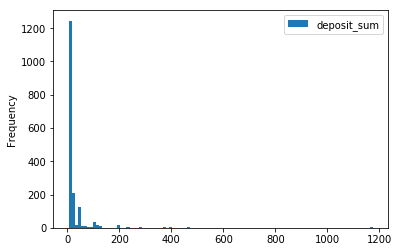

In [3]:
# The diagram is very skewed. We will try to normalize it a bit by removing outliers in the next step using IQR method
deposits.deposit_sum.plot(kind='hist', bins=100, legend=True)

0.25     7.0
0.50     7.0
0.75    22.0
Name: deposit_sum, dtype: float64
(1558, 8)


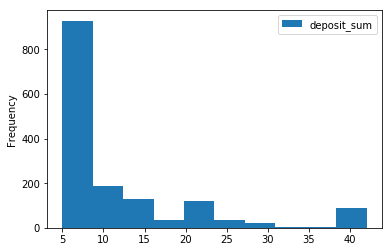

In [4]:
# using IQR method
print(deposits.deposit_sum.quantile([0.25, 0.5, 0.75]))
IQR = 22 - 7
lower = 7-1.5*IQR
upper = 22+1.5*IQR
deposits = deposits[deposits.deposit_sum<=upper]
deposits.deposit_sum.plot(kind='hist', legend=True)
print(deposits.shape)

**2. Определяем среднюю сумму депозитов на каждый уникальный traffic_source_id**

In [5]:
# Using SQL
conn = sqlite3.connect("depo.db") 
deposits.to_sql('depos', conn, if_exists='replace', index=False) 

mean_depo = pd.read_sql("""select sum(deposit_sum)/count(distinct user_id) as mean_deposit_traffic, 
traffic_source_id from depos group by traffic_source_id
order by mean_deposit_traffic desc;
                        """, conn, index_col='traffic_source_id')
mean_depo.head()

,mean_deposit_traffic
traffic_source_id,
7865,179
53947,179
49538,135
54021,117
54506,114


## 2. Проанализировать трейдерскую активность пользователей в разрезе по стране пользователя

Под понятием трейдерской активности мы подразумеваем общее количество уникальных пользователей, общую и среднюю сумму депозитов на страну
1. Рассчитать количество уникальных пользователей на каждую страну
2. Поиск и удаление выбросов по распределению частоты стран
3. Рассчитать среднюю сумму депозитов на страну согласно количеству уникальных пользователей (один пользователь может иметь несколько депозитов)

In [6]:
print(deposits.country.nunique())
deposits.head()     

81


,user_id,deposit_sum,deposit_date,deposit_platform,traffic_source_id,country,registration_platform,registration_date
1304,152142166,42,2017-09-01 00:24:00,Web,38997,Argentina,Web,2017-09-01 00:18:22
1305,152142166,14,2017-09-01 00:39:09,Web,38997,Argentina,Web,2017-09-01 00:18:22
1306,152144268,7,2017-09-01 01:45:57,Web,38977,Brazil,Web,2017-09-01 01:40:50
1307,152144754,5,2017-09-01 02:55:50,Ios,285,Brazil,Ios,2017-09-01 02:53:22
1308,152145436,6,2017-09-01 03:21:53,Android,27278,Indonesia,Android,2017-09-01 03:11:02


**1. Рассчитать количество уникальных пользователей на каждую страну**

In [7]:
# Существуют страны, имеющие малое количество уникальных пользователей 
# как в сравнительном так и в абсолютном плане. Для последующего анализа при подсчете средней суммы депозитов на 
# страну и уникального пользователя будет ненадежным включить страны, имеющих очень малое количество уникальных пользователей
# Соответственно, мы очистим данные от таких стран в следующем этапе. 
users_country = deposits.groupby('country')['user_id'].nunique().sort_values()
users_country.head()

# В зависимости от стоимости уникального юзера, следует снизить либо увеличить присутствие в странах.

country
Czech Republic    1
Ireland           1
Panama            1
Honduras          1
Grenada           1
Name: user_id, dtype: int64

**2. Поиск и удаление выбросов по частоте уникальных юзеров на страну**

In [8]:
# Оставим только страны, имеющие более 2 уникальных юзеров
countries = pd.DataFrame(users_country>2).reset_index()
countries = countries[countries['user_id']==True]
clean_deposits = deposits[deposits.country.isin(countries.country)]
clean_deposits.head()

,user_id,deposit_sum,deposit_date,deposit_platform,traffic_source_id,country,registration_platform,registration_date
1304,152142166,42,2017-09-01 00:24:00,Web,38997,Argentina,Web,2017-09-01 00:18:22
1305,152142166,14,2017-09-01 00:39:09,Web,38997,Argentina,Web,2017-09-01 00:18:22
1306,152144268,7,2017-09-01 01:45:57,Web,38977,Brazil,Web,2017-09-01 01:40:50
1307,152144754,5,2017-09-01 02:55:50,Ios,285,Brazil,Ios,2017-09-01 02:53:22
1308,152145436,6,2017-09-01 03:21:53,Android,27278,Indonesia,Android,2017-09-01 03:11:02


**2. Рассчитать среднюю сумму депозитов на страну согласно количеству уникальных пользователей (один пользователь может иметь несколько депозитов)**

In [9]:
# Средняя сумма депозитов на страну
users_per_country = clean_deposits.groupby('country')['user_id'].nunique()
depos_per_country = clean_deposits.groupby('country')['deposit_sum'].sum()
depo_users = depos_per_country/users_per_country
depo_users.sort_values().head() 

country
Kazakhstan      7.333333
Azerbaijan      7.666667
Serbia          9.750000
Albania        13.000000
Netherlands    13.333333
dtype: float64

General trend is that countries with higher incomes tend to deposit more, while states with less income invest in smaller amount respectively. 
But this is not a linear trend, as there are solid amount of cases, where this pattern is not a case.

## 3. Проанализировать трейдерскую активность пользователей отдельно в разрезе по идентификаторам актива (asset_id)
Вопрос какие идентификаторы актива самые популярные, наименее популярные (количество уникальных юзеров)
Какие идентификаторы актива приносят наибольшие сделки и наименьшие (deal_amount)


1. Count gross amount of unique user_id per asset_id
2. Average deal_amount per asset_id
3. Average win_amount per asset_id


In [12]:
deals = pd.read_csv('tt_real_deals.csv')
conn = sqlite3.connect("depo.db") 

print(deals.asset_id.nunique())
print(deals.shape) 
print(deals.user_id.nunique())
deals.sort_values('asset_id').head() 

54
(68120, 7)
512


,user_id,deal_amount,win_amount,direction,asset_id,deal_result,open_deal_time
40232,152382878,0.765,1.380,down,1,win,2017-09-07 13:39:13
32192,152144026,2.500,0.000,down,1,loose,2017-09-06 20:33:44
12866,152160190,1.000,0.000,up,1,loose,2017-09-04 21:58:03
47699,152356672,1.000,1.720,down,1,win,2017-09-08 04:18:59
12868,152298776,5.950,10.595,down,1,win,2017-09-04 21:58:10


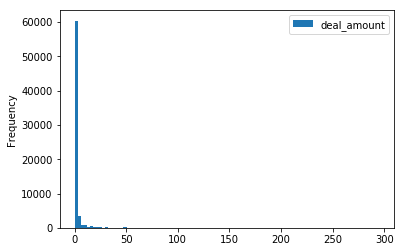

In [13]:
# The diagram is very skewed. We will try to normalize it a bit by removing outliers in the next step using IQR method
deals.deal_amount.plot(kind='hist', bins=100, legend=True)

**Dealing with outliers**

0.25    0.5
0.50    0.6
0.75    1.5
Name: deal_amount, dtype: float64
(60246, 7)


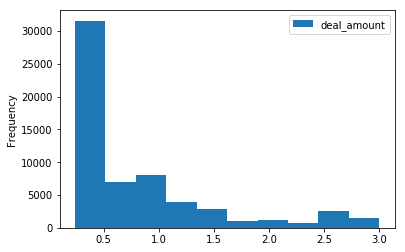

In [14]:
# IQR method
print(deals.deal_amount.quantile([0.25, 0.5, 0.75]))
IQR = 1.5 - 0.5
lower = 0.5-1.5*IQR
upper = 1.5+1.5*IQR
clean_deals = deals[deals.deal_amount<=upper]
print(clean_deals.shape)
clean_deals.to_sql('real_deals', conn, if_exists='replace', index=False)
clean_deals.deal_amount.plot(kind='hist', legend=True)

In [15]:
# Gross amount of unique user_id, gross and average deal_amount, gross and average win_amount per asset_id
users_per_asset = pd.read_sql("""select count(distinct user_id) as number_of_users, sum(deal_amount) as gross_deal_amount, 
sum(deal_amount)/count(distinct user_id) as average_deal_amount, sum(win_amount) as gross_win_amount, sum(win_amount)/count(distinct user_id) 
as average_win_amount, asset_id from real_deals group by asset_id
order by number_of_users desc;""", conn
)
# , index_col='asset_id'
users_per_asset.head()

,number_of_users,gross_deal_amount,average_deal_amount,gross_win_amount,average_win_amount,asset_id
0,307,9359.695,30.487606,8503.710,27.699381,1
1,206,4065.650,19.736165,3699.325,17.957888,99
2,206,5550.625,26.944782,5116.160,24.835728,101
3,166,2939.140,17.705663,2683.785,16.167380,212
4,164,2554.100,15.573780,2295.815,13.998872,100


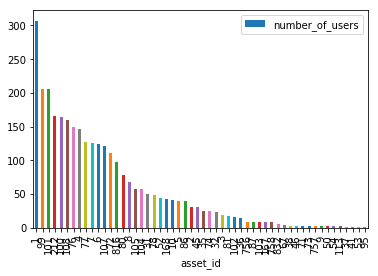

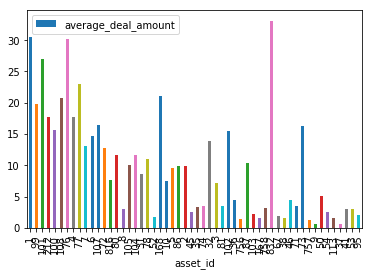

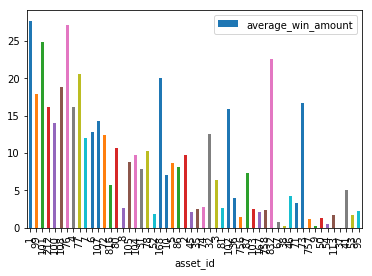

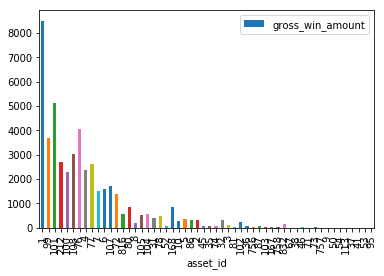

In [16]:
a = users_per_asset.plot('asset_id', 'number_of_users', kind='bar')
b = users_per_asset.plot('asset_id', 'average_deal_amount', kind='bar')
c = users_per_asset.plot('asset_id', 'average_win_amount', kind='bar')
d = users_per_asset.plot('asset_id', 'gross_win_amount', kind='bar')

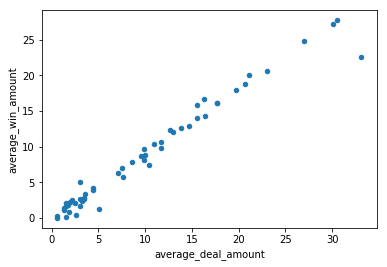

In [17]:
# Graph
users_per_asset.plot('average_deal_amount', 'average_win_amount', kind='scatter')

In [19]:
def results():
    deal_results = pd.DataFrame()
    deal_results['wins'] = deals[deals['deal_result']=='win']['deal_result'].groupby(deals['asset_id']).count()
    deal_results['lose'] = deals[deals['deal_result']=='loose']['deal_result'].groupby(deals['asset_id']).count()
    deal_results['equal'] = deals[deals['deal_result']=='equal']['deal_result'].groupby(deals['asset_id']).count()
    deal_results['sold'] = deals[deals['deal_result']=='sold']['deal_result'].groupby(deals['asset_id']).count()
    deal_results['cancelled'] = deals[deals['deal_result']=='canceled']['deal_result'].groupby(deals['asset_id']).count()
    deal_results.fillna(0, inplace=True)
    return deal_results.astype(int)
                           
results().head()                                                

,wins,lose,equal,sold,cancelled
asset_id,,,,,
1,5722,5395,448,515,3
2,173,140,6,50,0
3,49,56,4,17,0
4,1566,1469,63,154,3
5,183,176,11,37,0


**Conclusion**


**In the further analysis there can be **